# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [47]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
fatal: unable to access 'https://github.com/marcusklasson/GroceryStoreDataset.git/': Could not resolve host: github.com


In [48]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple
import torchvision.transforms as transforms

In [49]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("/kaggle/input/titles/GroceryStoreDataset-master/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

### imports

In [50]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import torch
from torch.optim.lr_scheduler import StepLR
import copy

### data preprocessing and augmentation
In this first step we transform both the train and the validation sets, this is done because we want to do some augmentation in order to reduce the bias of the network.
- at first the images are resized to 64x64 in order to ensure uniform input size
- then we have the data augmentation (of course, only for the training set) with RandomHorizontalFlip and RandomRotation
- finally we normalize the images 

In [51]:
# Data augmentation and normalization
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [52]:
# Step 1: Define the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the datasets
train_dataset = GroceryStoreDataset(split='train', transform=train_transforms)
val_dataset = GroceryStoreDataset(split='val', transform=val_transforms)
test_dataset = GroceryStoreDataset(split='test', transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### plotting functions

In [53]:
def plot_accuracy(train_acc, val_acc):
    
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_loss(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


### definition of training function
Here we define the training function. It takes as input the model, the train and val loader, as well as the criterion, optimizer, scheduler, number of epochs and patience. The total number of epoch is set to 20, although if there is no improvement after 5 steps the model stops training. At each epoch, we train on the train set and then evaluate the performance on the validation step.

In [54]:
def train_model_with_early_stopping_and_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, patience=5):
    """
    Train the model on the training set and evaluate it on the validation set, with early stopping and a learning rate scheduler.

    Args:
        model (nn.Module): The PyTorch model to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        criterion (nn.Module): Loss function used to calculate training and validation loss.
        optimizer (torch.optim.Optimizer): Optimizer for model weight updates.
        scheduler (torch.optim.lr_scheduler): Learning rate scheduler to adjust the learning rate during training.
        num_epochs (int, optional): Maximum number of training epochs. Default is 20.
        patience (int, optional): Number of consecutive epochs without validation accuracy improvement before early stopping. Default is 5.

    Returns:
        model (nn.Module): The trained model with the best weights (based on validation accuracy).
        train_loss_arr (list): List of training loss values for each epoch.
        train_acc_arr (list): List of training accuracy values for each epoch.
        val_loss_arr (list): List of validation loss values for each epoch.
        val_acc_arr (list): List of validation accuracy values for each epoch.
    """
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0
    early_stop = False
    
    train_loss_arr = []
    train_acc_arr = []
    val_loss_arr = []
    val_acc_arr = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        train_loss_arr.append(epoch_loss)
        train_acc_arr.append(epoch_acc)

        print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        
        val_loss_arr.append(val_loss)
        val_acc_arr.append(val_acc)

        print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        # Check if early stopping condition is met
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            early_stop = True
            break

        # Step the learning rate scheduler
        scheduler.step()

        print("-" * 20)

    # Restore best model weights
    print(f"Best val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, train_loss_arr, train_acc_arr, val_loss_arr, val_acc_arr


### definition of evaluation function
This function takes as input the model, the test loader and the criterion. It calculates the average test loss and the test accuracy by comparing the computed labels with the true ones. 

In [55]:
def evaluate_model_on_test_set(model, test_loader, criterion):
    """
    Evaluate the model on the test set.

    Args:
        model (nn.Module): Trained model to be evaluated.
        test_loader (DataLoader): DataLoader for the test dataset.
        criterion (nn.Module): Loss function to calculate test loss.

    Returns:
        test_loss (float): Average loss on the test set.
        test_accuracy (float): Accuracy on the test set.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_corrects = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            test_corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

    test_loss = test_loss / total_samples
    test_accuracy = test_corrects.double() / total_samples

    print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}')
    return test_loss, test_accuracy


### definition of loss function
In this class we define a variation of CrossEntropyLoss which also incorporates label smoothing, which is a regularization technique that adjusts the target labels during training by distributing a small portion of the target's "probability mass" to other classes.

In [56]:
# Label Smoothing Cross Entropy Loss
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        # Get number of classes
        num_classes = pred.size(1)
        
        # Create smoothed labels
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (num_classes - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), 1.0 - self.smoothing)
        
        return torch.mean(torch.sum(-true_dist * F.log_softmax(pred, dim=1), dim=1))

### definition of the network
The following is a CNN which is called EnhancedCNN because its predecessor, the SimpleCNN, of course was extremely basic and didn't perform as well. 
This network uses 2d convolutions, with 64, 128, 256, 512 filters. We choose the convolutional layers because it was requested by the task assignment (aka, build a convolutional neural network). The activation function is ReLU. 

We also use batch normalization and max pooling after the convolutional layers. Batch normalization is used specifically because it speeds up convergence and improves generalization. 

In [57]:
class EnhancedCNN(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedCNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)

        # Second convolutional block
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.batchnorm4 = nn.BatchNorm2d(512)

        # Global Average Pooling layer instead of flattening
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Output size of 1x1

        # Fully connected layers
        self.fc1 = nn.Linear(512, 1024)  # Adjust based on the output from the global avg pooling
        self.fc2 = nn.Linear(1024, num_classes)

        # Regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # First block
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))

        # Second block
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))
        x = self.pool(F.relu(self.batchnorm4(self.conv4(x))))

        # Global Average Pooling
        x = self.global_avg_pool(x)  # Output size becomes [batch_size, 512, 1, 1]
        x = x.view(x.size(0), -1)  # Flatten the tensor to [batch_size, 512]

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


### Training the model
As criterion we are using the **LabelSmoothingLoss** priorly defined, with smoothing parameter = 0.1. As an optimizer we are using **Adam**, which optimizes the model's weights in order to minimize the loss function. The parameter lr indicates the learning rate and sets the initial learning rate. Then the learning rate is adjusted via a scheduler, **StepLR** which dynamically adjusts the learning rate during training.

In [58]:
# Initialize the model, loss function, and optimizer
num_classes = train_dataset.get_num_classes()
model = EnhancedCNN(num_classes).to(device)
criterion = LabelSmoothingLoss(smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  


# Train the model with early stopping
trained_model, train_loss_arr, train_acc_arr, val_loss_arr, val_acc_arr = train_model_with_early_stopping_and_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=5)

# Save the best model
torch.save(trained_model.state_dict(), 'best_grocery_cnn.pth')


Epoch 1/30
Training Loss: 2.8906 Acc: 0.2557
Validation Loss: 2.7445 Acc: 0.2635
--------------------
Epoch 2/30
Training Loss: 2.3385 Acc: 0.4064
Validation Loss: 2.4428 Acc: 0.3919
--------------------
Epoch 3/30
Training Loss: 2.0762 Acc: 0.4955
Validation Loss: 2.3168 Acc: 0.3885
--------------------
Epoch 4/30
Training Loss: 1.9334 Acc: 0.5394
Validation Loss: 2.2773 Acc: 0.3986
--------------------
Epoch 5/30
Training Loss: 1.7740 Acc: 0.6136
Validation Loss: 2.1807 Acc: 0.4459
--------------------
Epoch 6/30
Training Loss: 1.6708 Acc: 0.6610
Validation Loss: 2.0787 Acc: 0.4865
--------------------
Epoch 7/30
Training Loss: 1.6079 Acc: 0.6826
Validation Loss: 2.1525 Acc: 0.5068
--------------------
Epoch 8/30
Training Loss: 1.5075 Acc: 0.7250
Validation Loss: 2.1156 Acc: 0.4561
--------------------
Epoch 9/30
Training Loss: 1.4509 Acc: 0.7583
Validation Loss: 2.2193 Acc: 0.4392
--------------------
Epoch 10/30
Training Loss: 1.3519 Acc: 0.7970
Validation Loss: 2.2673 Acc: 0.4966


### plots

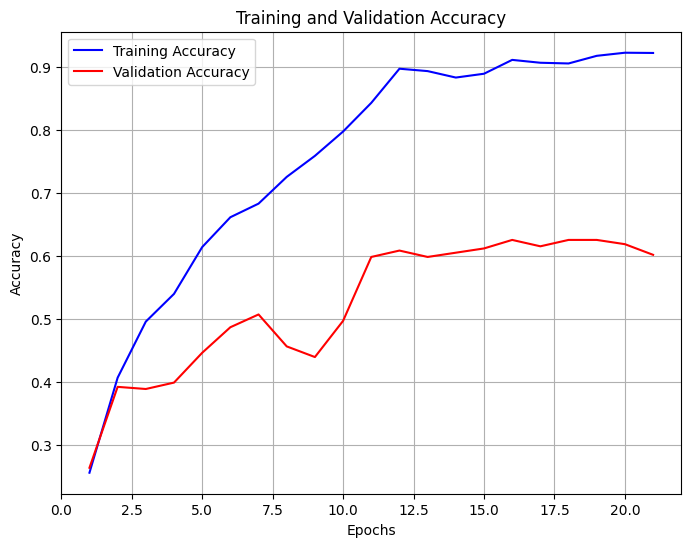

In [59]:
plot_accuracy(train_acc_arr, val_acc_arr)

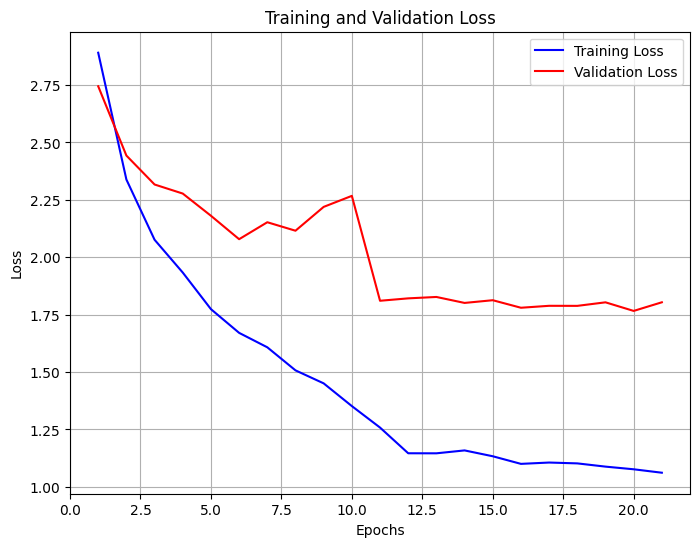

In [60]:
plot_loss(train_loss_arr, val_loss_arr)

In [61]:
model.load_state_dict(torch.load('best_grocery_cnn.pth'))
model.to(device)
test_loss, test_accuracy = evaluate_model_on_test_set(model, test_loader, criterion)

/tmp/ipykernel_24/1512604016.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_grocery_cnn.pth'))


Test Loss: 1.6524 | Test Accuracy: 0.6680


### PROVING THE MODEL
We decided to follow the ablation study approach. This means that we take out components of this networks (as well as reverting back some choices) in order to see how the performance is affected by these choices. 

In this first approach we remove the second convolutional block.

In [62]:
class EnhancedCNN_v2(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedCNN_v2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)

        # Global Average Pooling layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [63]:
# Initialize the model, loss function, and optimizer
num_classes = train_dataset.get_num_classes()
model = EnhancedCNN_v2(num_classes).to(device)
criterion = LabelSmoothingLoss(smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  


# Train the model with early stopping
trained_model_v2, train_loss_arr_v2, train_acc_arr_v2, val_loss_arr_v2, val_acc_arr_v2 = train_model_with_early_stopping_and_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=5)

# Save the best model
torch.save(trained_model.state_dict(), 'best_grocery_cnn_v2.pth')


Epoch 1/30
Training Loss: 3.0318 Acc: 0.2367
Validation Loss: 2.8686 Acc: 0.2534
--------------------
Epoch 2/30
Training Loss: 2.6336 Acc: 0.3220
Validation Loss: 2.6495 Acc: 0.3412
--------------------
Epoch 3/30
Training Loss: 2.4438 Acc: 0.3553
Validation Loss: 2.5906 Acc: 0.3514
--------------------
Epoch 4/30
Training Loss: 2.3165 Acc: 0.4087
Validation Loss: 2.6015 Acc: 0.3953
--------------------
Epoch 5/30
Training Loss: 2.2016 Acc: 0.4455
Validation Loss: 2.3873 Acc: 0.3986
--------------------
Epoch 6/30
Training Loss: 2.1118 Acc: 0.4864
Validation Loss: 2.3553 Acc: 0.3953
--------------------
Epoch 7/30
Training Loss: 2.0173 Acc: 0.5064
Validation Loss: 2.4031 Acc: 0.4223
--------------------
Epoch 8/30
Training Loss: 1.9772 Acc: 0.5269
Validation Loss: 2.4860 Acc: 0.3682
--------------------
Epoch 9/30
Training Loss: 1.8920 Acc: 0.5587
Validation Loss: 2.4164 Acc: 0.3716
--------------------
Epoch 10/30
Training Loss: 1.8486 Acc: 0.5799
Validation Loss: 2.3380 Acc: 0.3986


We notice already a pretty big drop in performance

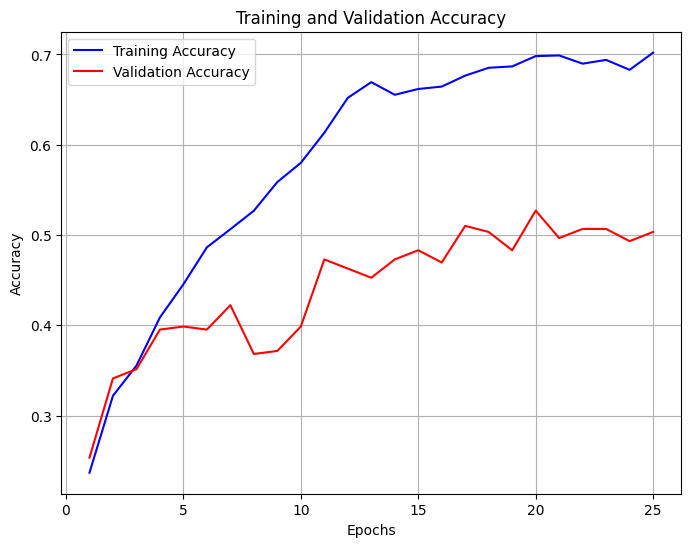

In [64]:
plot_accuracy(train_acc_arr_v2, val_acc_arr_v2)

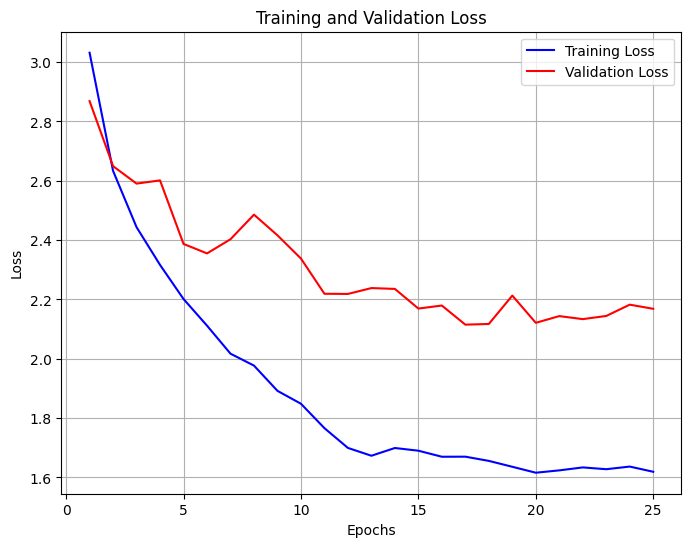

In [65]:
plot_loss(train_loss_arr_v2, val_loss_arr_v2)

The next step is to remove BatchNormalization

In [66]:
class EnhancedCNN_v3(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedCNN_v3, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Global Average Pooling layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [67]:
# Initialize the model, loss function, and optimizer
num_classes = train_dataset.get_num_classes()
model = EnhancedCNN_v3(num_classes).to(device)
criterion = LabelSmoothingLoss(smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  


# Train the model with early stopping
trained_model_v3, train_loss_arr_v3, train_acc_arr_v3, val_loss_arr_v3, val_acc_arr_v3 = train_model_with_early_stopping_and_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=5)

# Save the best model
torch.save(trained_model.state_dict(), 'best_grocery_cnn_v3.pth')


Epoch 1/30
Training Loss: 3.2937 Acc: 0.1674
Validation Loss: 3.0817 Acc: 0.2095
--------------------
Epoch 2/30
Training Loss: 2.8538 Acc: 0.2523
Validation Loss: 2.8277 Acc: 0.2736
--------------------
Epoch 3/30
Training Loss: 2.6227 Acc: 0.3292
Validation Loss: 2.7438 Acc: 0.2939
--------------------
Epoch 4/30
Training Loss: 2.4906 Acc: 0.3670
Validation Loss: 2.6072 Acc: 0.3108
--------------------
Epoch 5/30
Training Loss: 2.3824 Acc: 0.3883
Validation Loss: 2.6282 Acc: 0.3007
--------------------
Epoch 6/30
Training Loss: 2.2988 Acc: 0.4216
Validation Loss: 2.4909 Acc: 0.3649
--------------------
Epoch 7/30
Training Loss: 2.1865 Acc: 0.4564
Validation Loss: 2.4676 Acc: 0.3649
--------------------
Epoch 8/30
Training Loss: 2.1088 Acc: 0.4856
Validation Loss: 2.6219 Acc: 0.2804
--------------------
Epoch 9/30
Training Loss: 2.0502 Acc: 0.5064
Validation Loss: 2.5262 Acc: 0.3412
--------------------
Epoch 10/30
Training Loss: 1.9732 Acc: 0.5265
Validation Loss: 2.5453 Acc: 0.3142


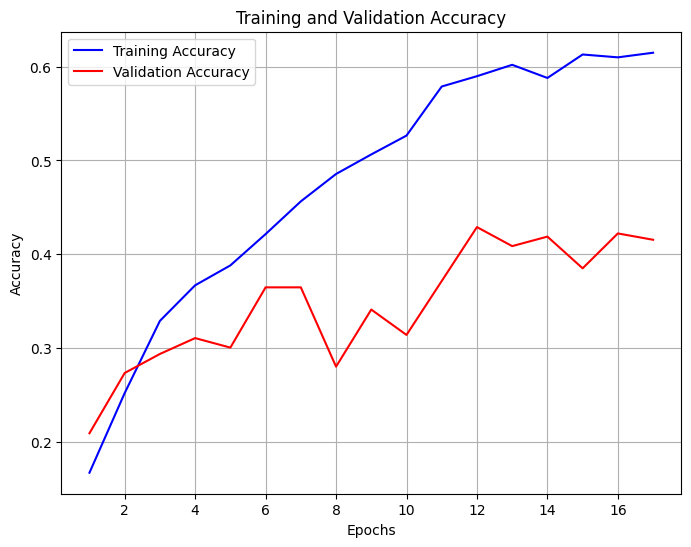

In [68]:
plot_accuracy(train_acc_arr_v3, val_acc_arr_v3)

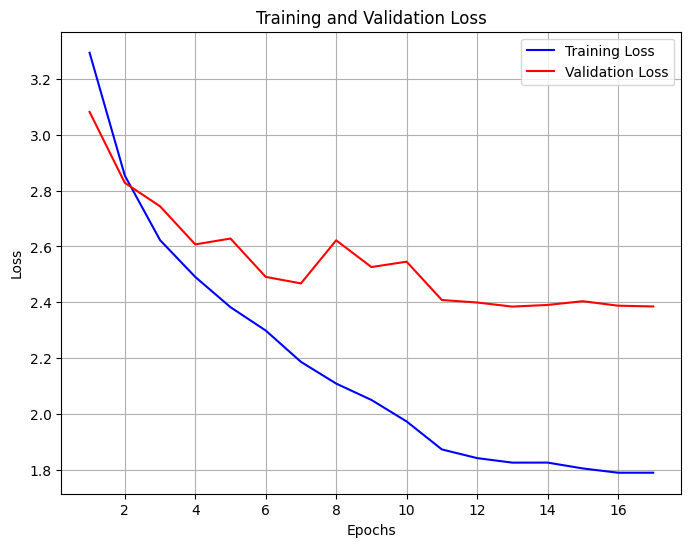

In [69]:
plot_loss(train_loss_arr_v3, val_loss_arr_v3)

The performance drops again if this is done. We can now remove GlobalAveragePooling

In [70]:
class EnhancedCNN_v4(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedCNN_v4, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Assumes input size is 64x64
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [71]:
# Initialize the model, loss function, and optimizer
num_classes = train_dataset.get_num_classes()
model = EnhancedCNN_v4(num_classes).to(device)
criterion = LabelSmoothingLoss(smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  


# Train the model with early stopping
trained_model_v4, train_loss_arr_v4, train_acc_arr_v4, val_loss_arr_v4, val_acc_arr_v4 = train_model_with_early_stopping_and_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=5)

# Save the best model
torch.save(trained_model.state_dict(), 'best_grocery_cnn_v4.pth')


Epoch 1/30
Training Loss: 3.1853 Acc: 0.1898
Validation Loss: 3.0787 Acc: 0.2162
--------------------
Epoch 2/30
Training Loss: 2.7060 Acc: 0.2989
Validation Loss: 2.9198 Acc: 0.2432
--------------------
Epoch 3/30
Training Loss: 2.5159 Acc: 0.3492
Validation Loss: 2.9176 Acc: 0.2500
--------------------
Epoch 4/30
Training Loss: 2.3779 Acc: 0.4019
Validation Loss: 2.8751 Acc: 0.2601
--------------------
Epoch 5/30
Training Loss: 2.2486 Acc: 0.4545
Validation Loss: 2.8064 Acc: 0.2973
--------------------
Epoch 6/30
Training Loss: 2.1399 Acc: 0.4871
Validation Loss: 2.7373 Acc: 0.2601
--------------------
Epoch 7/30
Training Loss: 2.0960 Acc: 0.4973
Validation Loss: 2.8096 Acc: 0.2872
--------------------
Epoch 8/30
Training Loss: 2.0244 Acc: 0.5428
Validation Loss: 2.7587 Acc: 0.3007
--------------------
Epoch 9/30
Training Loss: 1.9441 Acc: 0.5652
Validation Loss: 2.7389 Acc: 0.3074
--------------------
Epoch 10/30
Training Loss: 1.8950 Acc: 0.5864
Validation Loss: 2.8588 Acc: 0.2804


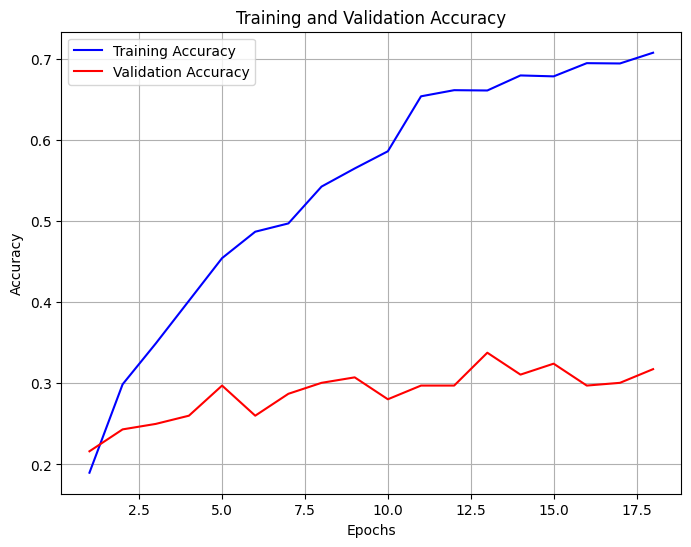

In [72]:
plot_accuracy(train_acc_arr_v4, val_acc_arr_v4)

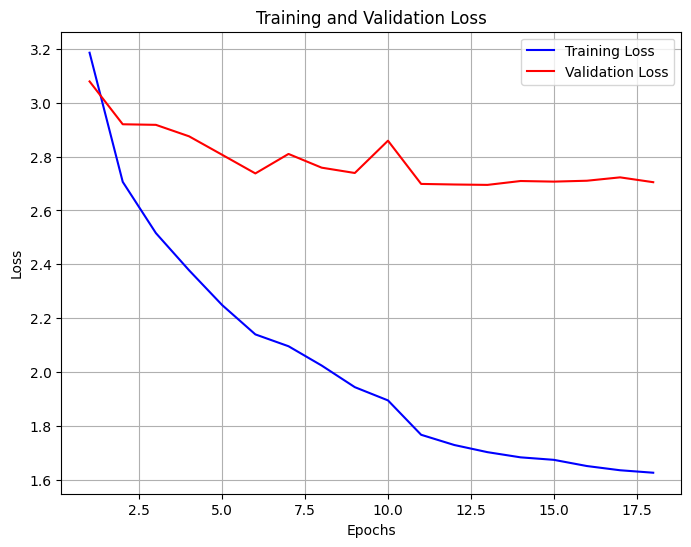

In [73]:
plot_loss(train_loss_arr_v4, val_loss_arr_v4)

This completes the ablation study and shows how the first model I proposed brings the best results. 

### Isolated step
In this last step, we check one more thing which goes to add value to the ablation study. We check if the main model (EnhancedCNN) performs as good with a simple CrossEntropyLoss instead of the LabelSmoothingLoss

In [74]:
# Initialize the model, loss function, and optimizer
num_classes = train_dataset.get_num_classes()
model = EnhancedCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  


# Train the model with early stopping
trained_model_ce, train_loss_arr_ce, train_acc_arr_ce, val_loss_arr_ce, val_acc_arr_ce = train_model_with_early_stopping_and_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=5)

# Save the best model
torch.save(trained_model.state_dict(), 'best_grocery_cnn_ce.pth')


Epoch 1/30
Training Loss: 2.5961 Acc: 0.2580
Validation Loss: 2.4267 Acc: 0.3209
--------------------
Epoch 2/30
Training Loss: 1.9855 Acc: 0.3705
Validation Loss: 2.1482 Acc: 0.4054
--------------------
Epoch 3/30
Training Loss: 1.5738 Acc: 0.4864
Validation Loss: 2.3401 Acc: 0.3986
--------------------
Epoch 4/30
Training Loss: 1.4017 Acc: 0.5299
Validation Loss: 2.5547 Acc: 0.2872
--------------------
Epoch 5/30
Training Loss: 1.2419 Acc: 0.5845
Validation Loss: 2.0212 Acc: 0.4020
--------------------
Epoch 6/30
Training Loss: 1.0322 Acc: 0.6500
Validation Loss: 1.6302 Acc: 0.5304
--------------------
Epoch 7/30
Training Loss: 0.9386 Acc: 0.6697
Validation Loss: 2.1185 Acc: 0.4054
--------------------
Epoch 8/30
Training Loss: 0.9087 Acc: 0.6879
Validation Loss: 1.8962 Acc: 0.5000
--------------------
Epoch 9/30
Training Loss: 0.8141 Acc: 0.7307
Validation Loss: 2.2892 Acc: 0.5000
--------------------
Epoch 10/30
Training Loss: 0.6884 Acc: 0.7777
Validation Loss: 2.5221 Acc: 0.3885


This shows that with the CrossEntropyLoss the results we reach are not that distant from the ones obtained through the LabelSmoothingLoss, they still do not surpass the acceptable threshold. 

### Further Exploration:
In this next part we thought about exploring a different type of model, which would exploit residual blocks instead of a double convolutional block. This second type of model should work better in deeper contexts or when dealing with bigger datasets, and they should improve generalization. They are also more complex and can be too much if the context is too simple. The fact that the previous model performs well even if it is more simple suggests that residual blocks may not be needed in this case, therefore this part is completely out of curiosity and to propose an alternative solution. 

In [75]:
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = F.relu(self.batchnorm1(self.conv1(x)))
        out = self.batchnorm2(self.conv2(out))
        out += identity
        out = F.relu(out)
        return out

class ResBlockCNN(nn.Module):
    def __init__(self, num_classes):
        super(ResBlockCNN, self).__init__()

        # First residual block
        self.res_block1 = ResidualBlock(3, 64, stride=1)
        self.res_block2 = ResidualBlock(64, 128, stride=2)

        # Second residual block
        self.res_block3 = ResidualBlock(128, 256, stride=2)
        self.res_block4 = ResidualBlock(256, 512, stride=2)

        # Global Average Pooling layer instead of flattening
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Output size of 1x1

        # Fully connected layers
        self.fc1 = nn.Linear(512, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

        # Regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Residual blocks
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        x = self.res_block4(x)

        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [76]:
num_classes = train_dataset.get_num_classes()
model = ResBlockCNN(num_classes).to(device)
criterion = LabelSmoothingLoss(smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  


# Train the model with early stopping
trained_model_res, train_loss_arr_res, train_acc_arr_res, val_loss_arr_res, val_acc_arr_res = train_model_with_early_stopping_and_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=5)

# Save the best model
torch.save(trained_model.state_dict(), 'best_grocery_cnn_res.pth')


Epoch 1/30
Training Loss: 2.8324 Acc: 0.2754
Validation Loss: 3.2584 Acc: 0.2601
--------------------
Epoch 2/30
Training Loss: 2.4393 Acc: 0.3739
Validation Loss: 2.6249 Acc: 0.3209
--------------------
Epoch 3/30
Training Loss: 2.2456 Acc: 0.4466
Validation Loss: 2.9538 Acc: 0.3176
--------------------
Epoch 4/30
Training Loss: 2.1020 Acc: 0.4837
Validation Loss: 2.4163 Acc: 0.4358
--------------------
Epoch 5/30
Training Loss: 1.9339 Acc: 0.5402
Validation Loss: 2.4226 Acc: 0.4257
--------------------
Epoch 6/30
Training Loss: 1.8816 Acc: 0.5667
Validation Loss: 2.2299 Acc: 0.4257
--------------------
Epoch 7/30
Training Loss: 1.7433 Acc: 0.6148
Validation Loss: 2.4718 Acc: 0.4189
--------------------
Epoch 8/30
Training Loss: 1.6515 Acc: 0.6640
Validation Loss: 2.1520 Acc: 0.5034
--------------------
Epoch 9/30
Training Loss: 1.5780 Acc: 0.6902
Validation Loss: 2.1626 Acc: 0.4561
--------------------
Epoch 10/30
Training Loss: 1.5614 Acc: 0.7061
Validation Loss: 2.3982 Acc: 0.4527


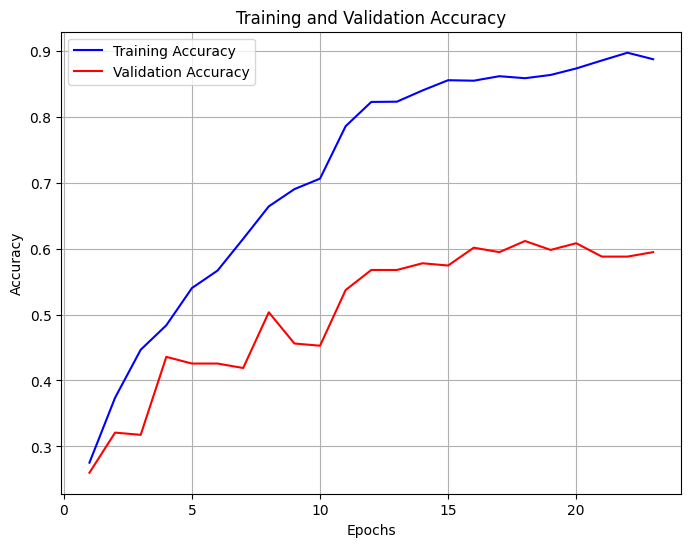

In [77]:
plot_accuracy(train_acc_arr_res, val_acc_arr_res_res)

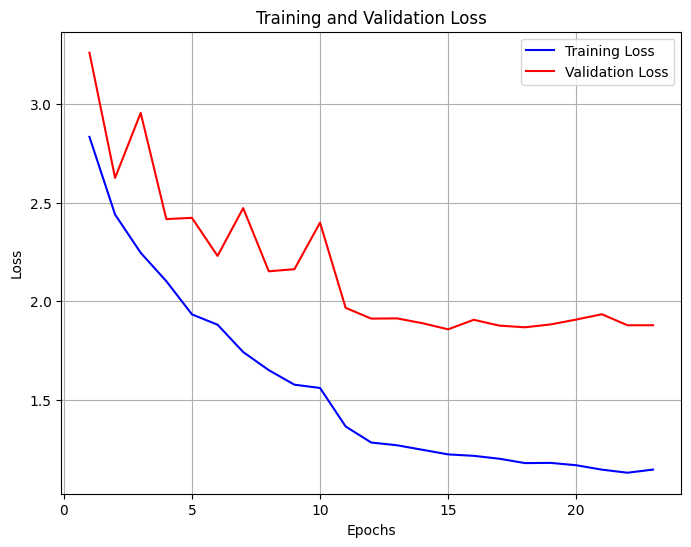

In [78]:
plot_loss(train_loss_arr_res, val_loss_arr_res)

As expected, the results are still good (or acceptable for the task at hand), but the training time is much longer. 

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.